<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-hw2/blob/main/BLM6114_hw2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrGLUE: cola ve sst2 üzerinde embedding + sınıflandırma

### Gereken kütüphaneleri yükle

In [7]:
!pip install -q datasets sentence-transformers scikit-learn

### Gerekli importlar

In [8]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

### Verilerin yüklenmesi

In [9]:
# SST2
sst2 = load_dataset("turkish-nlp-suite/TrGLUE", "sst2")
sst2_train = sst2['train'].shuffle(seed=42).select(range(5000))  # Eğitim: 60K -> 5K
sst2_test = sst2['test'].shuffle(seed=42).select(range(1000))  # Test: 9K -> 1K

# CoLA
cola = load_dataset("turkish-nlp-suite/TrGLUE", "cola")
cola_train = cola['train'].shuffle(seed=42).select(range(5000))  # Eğitim: 5K
cola_test = cola['test']  # Test: Tüm test kümesi


## Embedding ayarlamaları

In [10]:
models = {
    "berturk": SentenceTransformer("dbmdz/bert-base-turkish-cased"),
    "kalm": SentenceTransformer("HIT-TMG/KaLM-embedding-multilingual-mini-v1"),
    "e5": SentenceTransformer("intfloat/multilingual-e5-large-instruct"),
    "miniLM": SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"),
    "xlm-roberta": SentenceTransformer("xlm-roberta-base")
}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/601k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


tokenizer_config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

### Hesaplama ve değerlendirme

In [13]:
# Embedding hesaplama fonksiyonu
def embed_texts(model, texts, prefix=""):
    return model.encode([prefix + text for text in texts], show_progress_bar=True)

# Değerlendirme fonksiyonu
def evaluate_model(X_train, y_train, X_test, y_test):
    classifiers = {
        "RandomForest": RandomForestClassifier(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "SVM": SVC()
    }
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = {
            "accuracy": acc,
            "report": classification_report(y_test, preds, output_dict=True)
        }
    return results

#Tüm kombinasyonlar için döngü
results = {}

for model_name, model in tqdm(models.items()):
    # cola için
    X_train = embed_texts(model, [ex["sentence"] for ex in cola_train], prefix=("query: " if model_name == "e5" else ""))
    X_test = embed_texts(model, [ex["sentence"] for ex in cola_test], prefix=("query: " if model_name == "e5" else ""))
    y_train = [ex["label"] for ex in cola_train]
    y_test = [ex["label"] for ex in cola_test]
    results[f"cola_{model_name}"] = evaluate_model(X_train, y_train, X_test, y_test)

    # sst2 için
    X_train = embed_texts(model, [ex["sentence"] for ex in sst2_train], prefix=("query: " if model_name == "e5" else ""))
    X_test = embed_texts(model, [ex["sentence"] for ex in sst2_test], prefix=("query: " if model_name == "e5" else ""))
    y_train = [ex["label"] for ex in sst2_train]
    y_test = [ex["label"] for ex in sst2_test]
    results[f"sst2_{model_name}"] = evaluate_model(X_train, y_train, X_test, y_test)


  0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:07<04:30, 67.68s/it]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 40%|████      | 2/5 [03:49<06:08, 122.98s/it]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 60%|██████    | 3/5 [06:08<04:20, 130.18s/it]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

 80%|████████  | 4/5 [06:49<01:35, 95.05s/it] 

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 5/5 [08:03<00:00, 96.64s/it]


### Sonuçlar

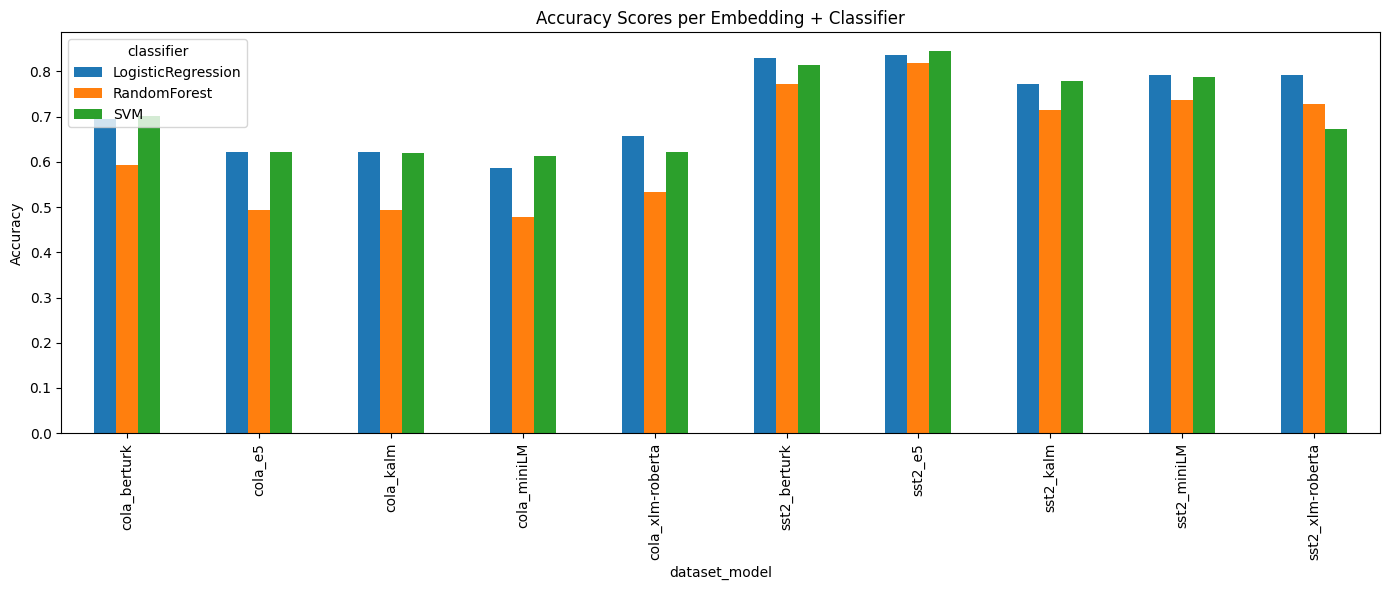

In [14]:
summary = []
for key, clf_results in results.items():
    for clf, metrics in clf_results.items():
        summary.append({
            "dataset_model": key,
            "classifier": clf,
            "accuracy": metrics["accuracy"]
        })

df = pd.DataFrame(summary)
df.pivot(index="dataset_model", columns="classifier", values="accuracy").plot(kind="bar", figsize=(14, 6))
plt.title("Accuracy Scores per Embedding + Classifier")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()